# ✅ 실습참여 파일 제출안내
- Task : 아이캠퍼스에서 실습용 파일 다운받아서, 빈칸 채우기
- 파일명: lab06-학번.ipynb
- 아이캠퍼스에 제출
- 기한: 오늘 자정까지 (23:59)

---

## 🛄 Review : Lab05
- Deep learning Pipeline
- Node Classification
- Link Prediction

## 🛄 Overview: Lab06
- Reveiw (LAB05)
- Graph Classification
- Graph Convolution Network (GCN)

---

# ✅ LAB05 - Review

## ✔︎ Deep Learning Pipeline
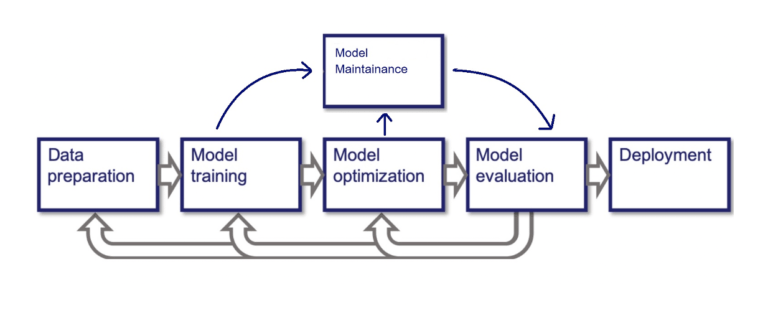

1. 데이터셋 및 데이터로더 정의
2. 모델 정의
3. 훈련 루프 정의
4. 평가 루프 정의

## ✔︎ Graph Learning 

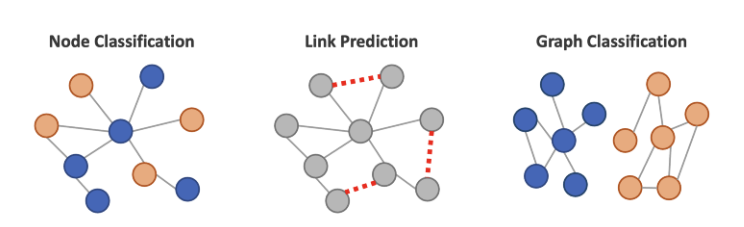


[출처] https://towardsdatascience.com/graph-neural-networks-with-pyg-on-node-classification-link-prediction-and-anomaly-detection-14aa38fe1275

### 1. Node Classification 
- 각 노드들이 어떤 class에 해당되는지 맞추는 Task
- ex) 각 노드가 paper로 구성된 network가 있다고 할 때, 특정 paper가 어떤 주제에 해당될 지 맞춤.

### 2. Link Prediction
- 노드 간 연결 유무를 맞추는 Task 
- ex) 각 노드가 paper이며, 인용 여부에 따라 edge가 구성된 network가 있다고 할 때, 특정 paper node가 다른 paper node와 연결될 지 맞춤.

### 3. Graph Classification
- 개별 그래프들을 보고, 해당 그래프가 어떤 class에 해당되는지 맞추는 Task
- ex) 화합물에 대한 graph로 구성된 graph set이 있다고 가정할 때, 각 화합물의 성질이 독성인지 무독성인지 맞춤.

---

## ✔︎ Node Classification
- 목표 : 그래프 구조에 따라 노드 임베딩 학습 후, 각 노드들이 어떤 class에 해당되는지 맞춤.

## 1. 데이터 로드

In [1]:
import torch
print("PyTorch has version {}".format(torch.__version__))

PyTorch has version 1.10.2


In [2]:
!pip install -q dgl-cu113 dglgo -f https://data.dgl.ai/wheels/repo.html

ERROR: Could not find a version that satisfies the requirement dgl-cu113 (from versions: none)
ERROR: No matching distribution found for dgl-cu113


In [3]:
# data load
import dgl.data

dataset = dgl.data.CoraGraphDataset()
print('Number of categories:', dataset.num_classes)

ModuleNotFoundError: No module named 'dgl'

2708개의 노드, 10556개의 엣지로 이루어진 그래프의 각 노드들을 7개의 클래스 중 하나로 분류

## 2. 모델 정의
### GNN Class 정의에 필요한 요소
    1. input_feature의 차원 : 초기 feature matrix 크기
    2. output_feature의 차원 : hyper parameter
    3. num_classes : 최종 예측 클래스 수 
    
### GraphConv의 역할
    1. graph와 node feature를 입력으로 받음.
    2. graph에 따라 node feature를 gcn 연산을 통해 업데이트
    3. output feature 크기의 업데이트된 피쳐 반환

In [4]:
from dgl.nn import GraphConv
import torch.nn as nn

class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, num_classes)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

In [5]:
g = dataset[0]

In [6]:
# Create the model with given dimensions
model = GCN(g.ndata['feat'].shape[1], 16, dataset.num_classes)
model

GCN(
  (conv1): GraphConv(in=1433, out=16, normalization=both, activation=None)
  (conv2): GraphConv(in=16, out=7, normalization=both, activation=None)
)

## 3. 훈련/평가 루프 구성

1. **(Define)** Optimizer, Loss Function 정의
2. **(Forward)** GCN 모델을 통과시켜, 업데이트된 node feature 반환받음. (out_feat: num_classes)
3. **(Backward)** gradient descent 및 가중치 업데이트 수행. 
4. **(Prediction)** 가장 값이 높은 항목을 예측 인덱스로 설정.
5. **(Evaluation)** train/valid mask에 따라 각각 평가

In [7]:
def train(g, features, labels, train_mask, val_mask):
    # 학습에 필요한 요소 정의 
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    loss = F.cross_entropy(logits[train_mask], labels[train_mask])
    best_val_acc = 0

    # Forward
    model.train()
    logits = model(g, features)

    # Backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Compute prediction
    pred = logits.argmax(1)

    # Compute accuracy on training/validation/test
    train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
    val_acc = (pred[val_mask] == labels[val_mask]).float().mean() # 정석은 model.eval() 해줘야함

    # Save the best validation accuracy and the corresponding test accuracy.
    if best_val_acc < val_acc:
        best_val_acc = val_acc

    return loss, logits, val_acc, best_val_acc

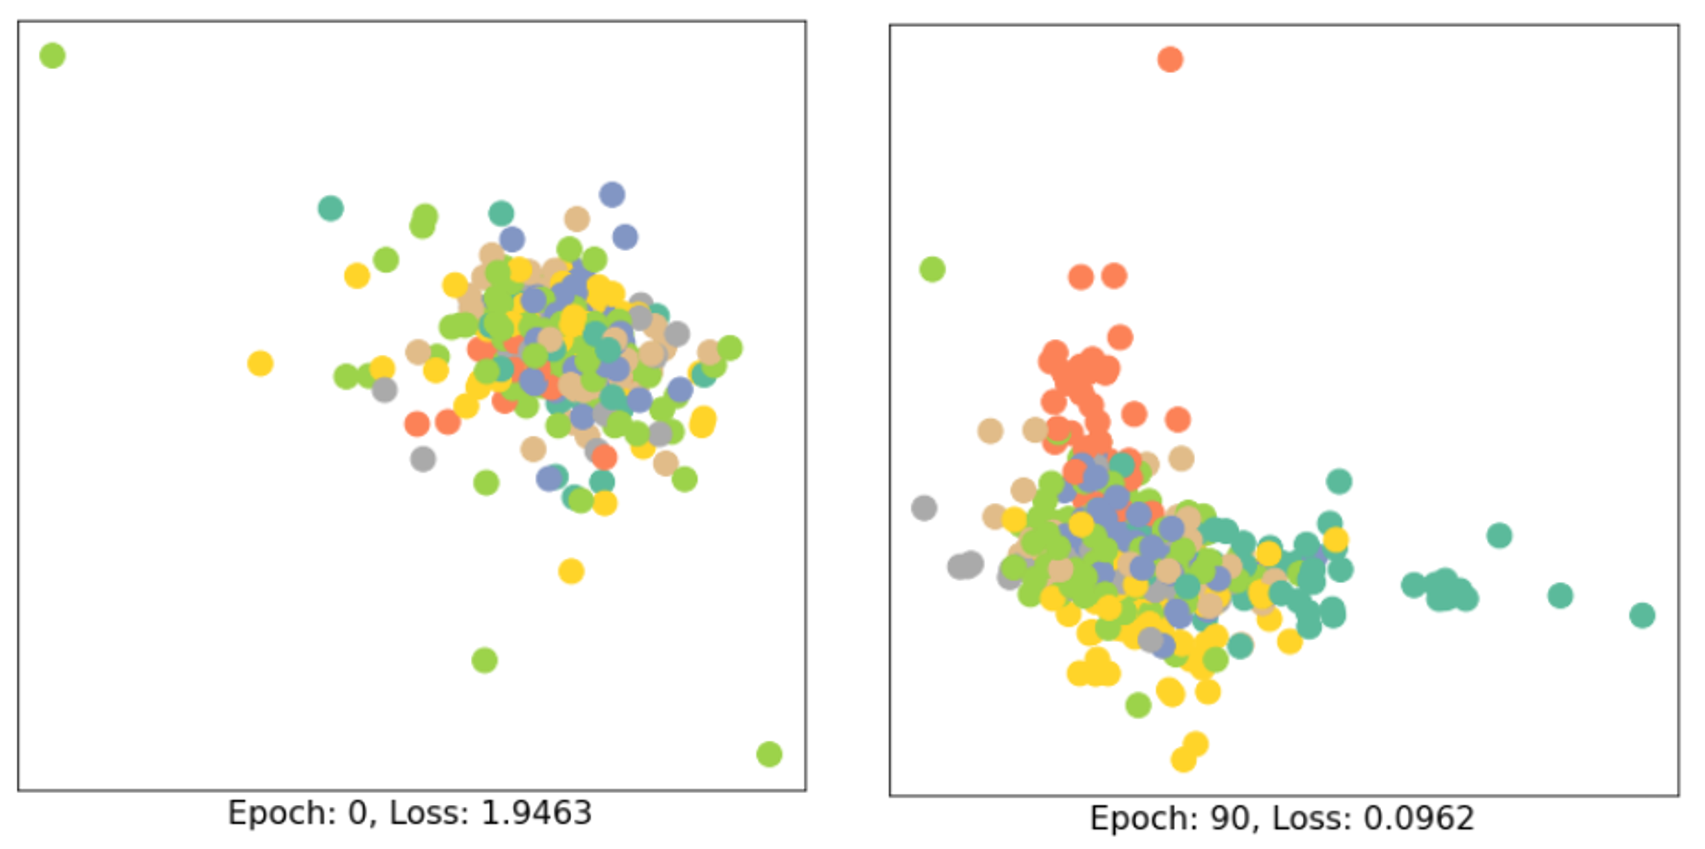

## 4. Train/Valid Mask
- transductive learning : 전체 그래프 구조를 입력으로 넣되, 학습에 이용할 노드와 평가에 사용할 노드는 따로 정의함. 
- 이때 각 노드가 학습에 이용할 노드인지, 평가에 이용할 노드인지 알려주기 위해 정의하는 것이 train/valid mask임.

---

## ✔︎ Link Prediction
- positive graph : Graph에 존재하는 edge
- negative graph : Graph에 존재하지 않는 edge
- objective function : 
    - 노드 u와 v 간의 score가 노드 u와 v'간의 score 보다 높도록 학습 (negative sampling)

## 1. 데이터 로드

In [8]:
import dgl.data

dataset = dgl.data.CoraGraphDataset()
g = dataset[0]

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


## 2. Negative Sampling

In [9]:
import scipy.sparse as sp
import numpy as np 

u, v = g.edges() # source, target edges

In [10]:
# positive graph
adj = sp.coo_matrix((np.ones(len(u)), (u.numpy(), v.numpy())))
adj.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 1.],
        [0., 0., 0., ..., 0., 1., 0.]])

In [11]:
# negative graph 
adj_neg = 1 - adj.todense() - np.eye(g.number_of_nodes()) # self loop, 자기 자신를 향하는 edge(예, (0, 0)의 경우)도 제외
adj_neg

matrix([[0., 1., 1., ..., 1., 1., 1.],
        [1., 0., 0., ..., 1., 1., 1.],
        [1., 0., 0., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 0., 1., 1.],
        [1., 1., 1., ..., 1., 0., 0.],
        [1., 1., 1., ..., 1., 0., 0.]])

In [12]:
neg_u, neg_v = np.where(adj_neg != 0) # 0 값이 아닌 edge 정보 추출
neg_u, neg_v

(array([   0,    0,    0, ..., 2707, 2707, 2707]),
 array([   1,    2,    3, ..., 2703, 2704, 2705]))

## 3. 모델 정의

In [13]:
from dgl.nn import SAGEConv

# build a two-layer GraphSAGE model
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, 'mean')
        self.conv2 = SAGEConv(h_feats, h_feats, 'mean')

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

In [14]:
model = GraphSAGE(g.ndata['feat'].shape[1], 16)

## 4. 훈련 및 평가 루프
1. model로부터 업데이트된 node feature 반환
2. postive graph의 스코어, negative graph의 스코어 구하기 (DotProduct)
3. positive graph 내 엣지들은 스코어가 1이 되도록, negative graph 내 엣지들은 스코어가 0이 되도록 학습

In [15]:
def train(train_g):
    model.train()
    optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)
    h = model(train_g, train_g.ndata['feat'])
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss

In [16]:
import dgl.function as fn

# 계산 방식 다양
class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            # Compute a new edge feature named 'score' by a dot-product between the
            # source node feature 'h' and destination node feature 'h'.
            g.apply_edges(fn.u_dot_v('h', 'h', 'score')) # u와 v를 element-wise dot 하고, 이 값을 변수명 score로 지정
            # u_dot_v returns a 1-element vector for each edge so you need to squeeze it.
            return g.edata['score'][:, 0]

pred = DotPredictor()

In [17]:
def compute_loss(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
    return F.binary_cross_entropy_with_logits(scores, labels)

---

# ✅ Lab06 - Graph Classification
https://docs.dgl.ai/en/0.9.x/guide_ko/training-graph.html

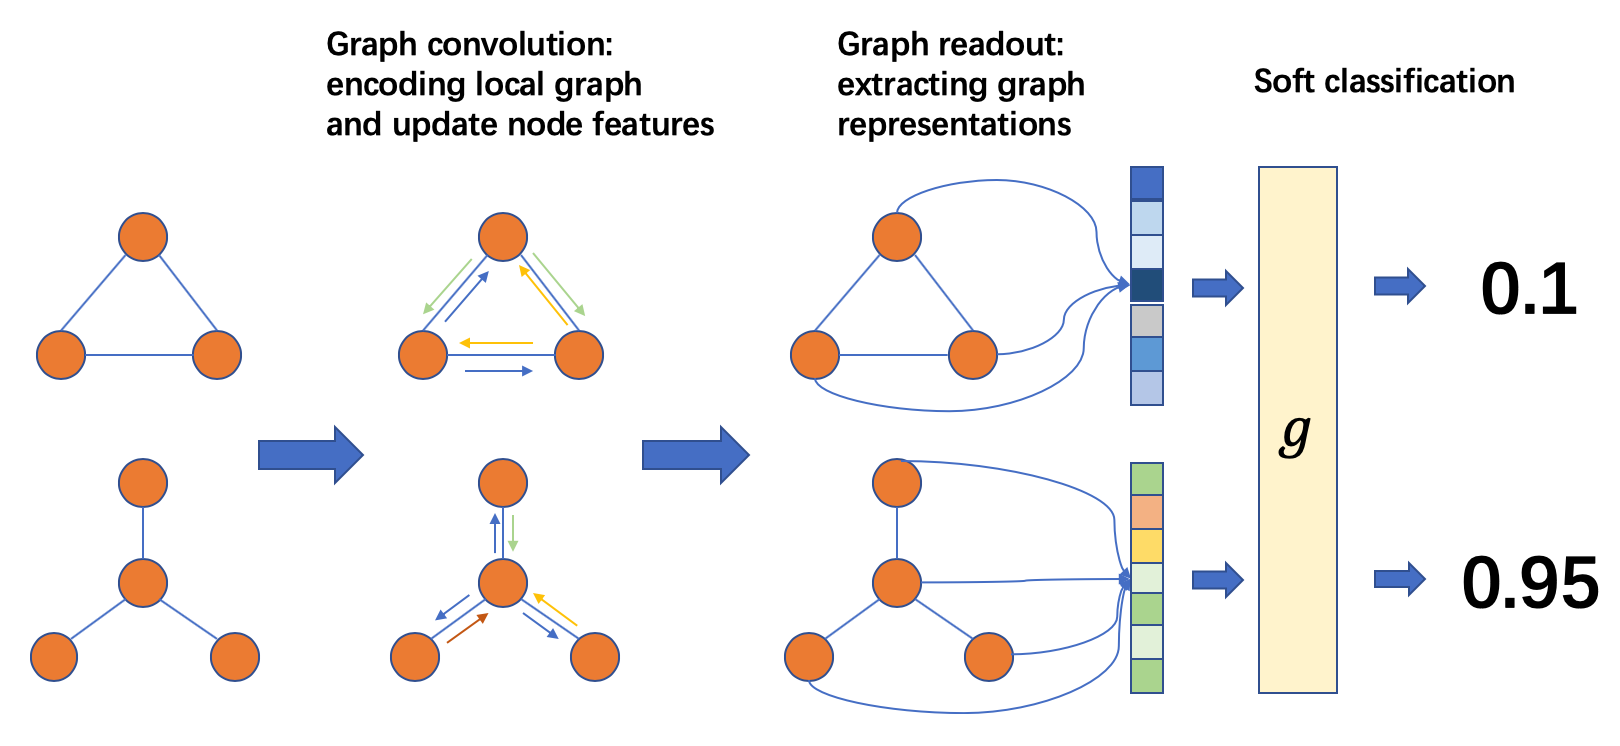

- 노드 분류나 링크 예측과 가장 큰 차이점은, 일부 노드 / 일부 엣지가 아닌 **전체 그래프의 특성을 나타내는 예측 결과를 뽑아내야 한다는 것** 임.

## ✔︎ 일반적인 학습 순서

1. 그래프들의 배치를 준비함.
2. 배치에 대해 GNN 연산을 수행하여 노드/엣지 피쳐 업데이트
3. 노드/엣지 피쳐를 모두 합쳐서 그래프 수준의 representation 만들기 (readout)
4. 그래프 단위의 representation을 활용해 최종 분류 

## ✔︎  그래프들의 배치 
- 지금까지는 전체 그래프를 대상으로 학습을 했음! (전체 연결 구조를 학습해서 업데이트 하고자)
- 근데 이제는 개별 그래프의 representation을 뽑을 거니까, 이미지 분류, 텍스트 분류에서 처럼 배치 단위로 나누어 학습할 수 있다!

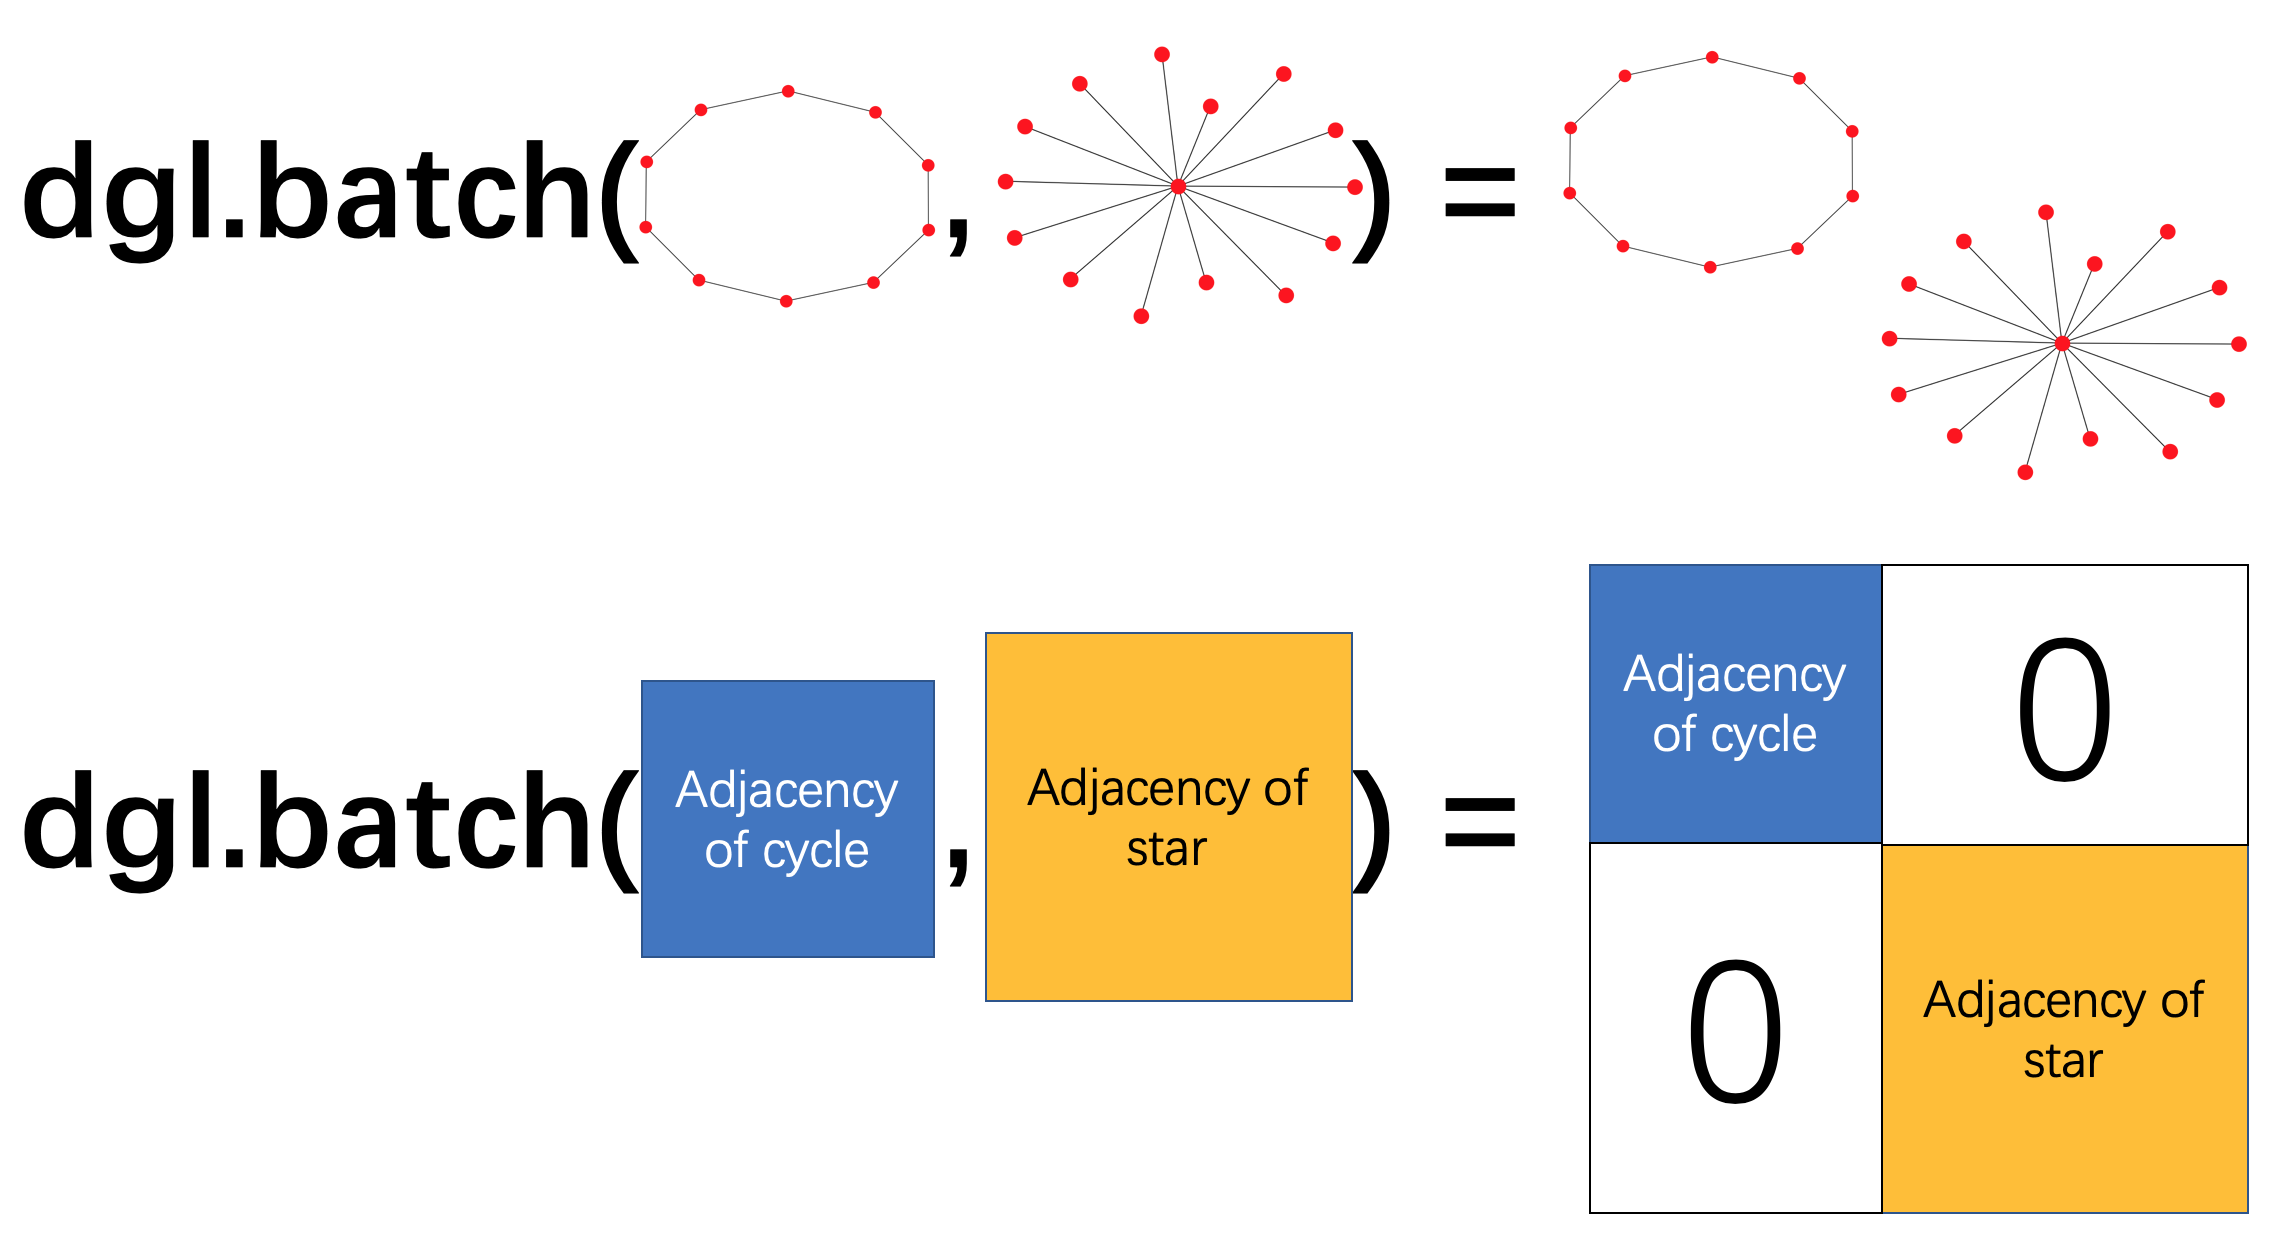

- 그래프에서의 배치는 여러 개의 개별 그래프를 하나로 통합해 batch graph로 만들어 입력으로 넣어주는 방식을 활용할 수 있음.
- 이 batch graph는 하나의 큰 그래프지만, 내부에는 여러 개의 그래프가 개별적으로 존재한다는 것이 각 컴포넌트 요소들에 의해 구별 가능함.

## ✔︎ Environment Setting

In [ ]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl.data

## 1. Load Dataset
- PROTEINS dataset : 단백질 구조를 효소가 아닌지, 맞는지 분류하는 그래프 분류 문제를 위한 데이터셋

In [ ]:
# Generate a synthetic dataset with 10000 graphs, ranging from 10 to 500 nodes.
dataset = dgl.data.GINDataset('PROTEINS', self_loop=True)

Extracting file to /root/.dgl/GINDataset


In [ ]:
# 개별 그래프 확인 (총 1113개의 그래프가 포함)
len(dataset.graphs), dataset.graphs

In [ ]:
# 라벨 확인 (Task: 0 또는 1인 이진 분류)
print('Number of graph categories:', dataset.gclasses)
len(dataset.labels), dataset.labels

In [ ]:
# Node Feature의 Dimension
print('Node feature dimensionality:', dataset.dim_nfeats)

In [ ]:
# 전체 데이터 크기, 학습 데이터 크기 정의
num_examples = #-----code-----#
num_train = #-----code-----#

In [ ]:
num_examples, num_train

(1113, 890)

## 2. DataLoader
- 앞서 언급한 것과 같이, 전체 각 그래프를 전부 다 학습하기보다는 배치 단위로 묶어 학습
- DataLoader와 Sampler를 활용해 배치 그래프 구축

In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler

train_sampler = SubsetRandomSampler(torch.arange(num_train))
test_sampler = SubsetRandomSampler(torch.arange(num_train, num_examples))

In [ ]:
from dgl.dataloading import GraphDataLoader

train_dataloader = GraphDataLoader(
    dataset, sampler=train_sampler, batch_size=32, drop_last=False)
test_dataloader = GraphDataLoader(
    dataset, sampler=test_sampler, batch_size=32, drop_last=False)

### SubsetRandomSampler
- 인자로 전달한 indices 중에서 랜덤으로 뽑아 각 배치 구성
- 초기에 index들의 순서를 Random으로 섞고, 해당 인덱스로 데이터를 구성하는 것과 같은 원리 

### Batch Graph 확인

In [ ]:
# batch size 만큼의 그래프들이 합쳐져 batch graph가 된 모습을 볼 수 있음.
it = iter(train_dataloader)
batch = next(it)
print(batch)

[Graph(num_nodes=1336, num_edges=6304,
      ndata_schemes={'attr': Scheme(shape=(3,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={}), tensor([1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 1, 0, 1, 0, 1, 1, 0])]


In [ ]:
batched_graph, labels = batch
print('Number of nodes for each graph element in the batch:', batched_graph.batch_num_nodes())
print('Number of edges for each graph element in the batch:', batched_graph.batch_num_edges())

Number of nodes for each graph element in the batch: tensor([ 26,  21,  23,  21,  16,  23,  30,   4,  63,  23,  55,  23,  95,  30,
         28,  39,  69,  31,  19,  33,  48,  31,  71,  47,  96,  21, 154,  13,
         16,  26,  10, 131])
Number of edges for each graph element in the batch: tensor([110,  97, 107, 107,  84, 103, 138,  16, 325, 103, 209, 115, 469, 152,
        134, 203, 357, 135,  93, 189, 206, 143, 377, 235, 370, 105, 716,  73,
         74, 122,  46, 591])


In [ ]:
# 만약 original graph들로 쪼개어 보고 싶다면 unbatch 활용.
graphs = #-----code-----#
print('The original graphs in the minibatch:')
print(graphs)

The original graphs in the minibatch:
[Graph(num_nodes=26, num_edges=110,
      ndata_schemes={'attr': Scheme(shape=(3,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={}), Graph(num_nodes=21, num_edges=97,
      ndata_schemes={'attr': Scheme(shape=(3,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={}), Graph(num_nodes=23, num_edges=107,
      ndata_schemes={'attr': Scheme(shape=(3,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={}), Graph(num_nodes=21, num_edges=107,
      ndata_schemes={'attr': Scheme(shape=(3,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={}), Graph(num_nodes=16, num_edges=84,
      ndata_schemes={'attr': Scheme(shape=(3,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={}), Graph(num_nodes=23, num_edges=103,
      ndata_schemes={'attr': Scheme(shape=(3,), 

## 3. 모델 정의
- 입력으로 graph, feature를 받아, 이에 따라 feature를 업데이트하는 과정은 동일.
- 다만, 마지막에 mean_nodes함수를 통해 readout 수행
- 이는 각 그래프 내의 node feature의 값을 평균낸 것으로, graph의 representation으로 활용됨.
- 이외에 흔히 쓰이는 readout 연산으로는 sum, max, min 등이 있음.

In [ ]:
from dgl.nn import GraphConv

class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, h_feats)
        self.classifier = nn.Linear(h_feats, num_classes)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        g.ndata['h'] = h
        # Calculate graph representation by average readout
        hg = dgl.mean_nodes(g, 'h') # readout
        return self.classifier(hg)

In [ ]:
# Create the model with given dimensions
model = #-----code-----#

## 4. 훈련/평가 루프 정의

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
for epoch in range(100):
    total_loss = 0
    for batched_graph, labels in train_dataloader:
        # Forward
        pred = #-----code-----#
        
        # Calculate loss
        loss = loss_fn(pred, labels)
        total_loss += loss
            
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if epoch % 10 == 0:
        print('In epoch {}, loss: {}'.format(epoch, loss))

In epoch 0, loss: 0.6082170605659485
In epoch 10, loss: 0.45908546447753906
In epoch 20, loss: 0.6243695616722107
In epoch 30, loss: 0.4003865122795105
In epoch 40, loss: 0.3643990755081177
In epoch 50, loss: 0.6487551927566528
In epoch 60, loss: 0.731148362159729
In epoch 70, loss: 0.5234353542327881
In epoch 80, loss: 0.6325178742408752
In epoch 90, loss: 0.40398332476615906


In [ ]:
# Test셋에 대해 평가
with torch.no_grad():
    model.eval()
    num_correct = 0
    num_tests = 0
    for batched_graph, labels in test_dataloader:
        pred = model(batched_graph, batched_graph.ndata['attr'].float())
        num_correct += (pred.argmax(1) == labels).sum().item()
        num_tests += len(labels)

In [ ]:
print('Test accuracy:', num_correct / num_tests)

Test accuracy: 0.34977578475336324


# ✅ GCN (Graph Convolution Network)

- Computer Vision에서의 Convolution 연산 아이디어를 Graph에 적용
- 타겟 노드에 대해, 해당 노드와 연결된 이웃 노드들의 정보를 취합해 타겟 노드의 피쳐를 업데이트하고자 함.

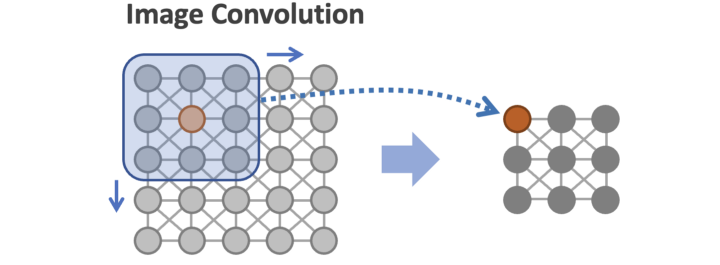

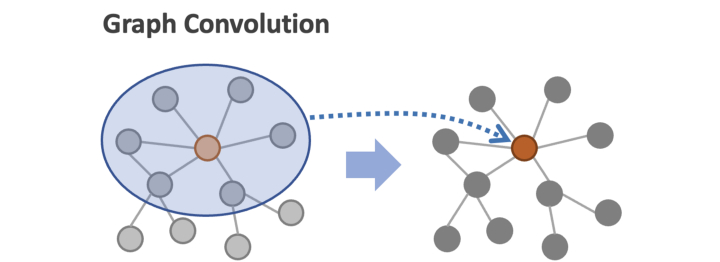

[출처] https://towardsdatascience.com/graph-neural-networks-with-pyg-on-node-classification-link-prediction-and-anomaly-detection-14aa38fe1275

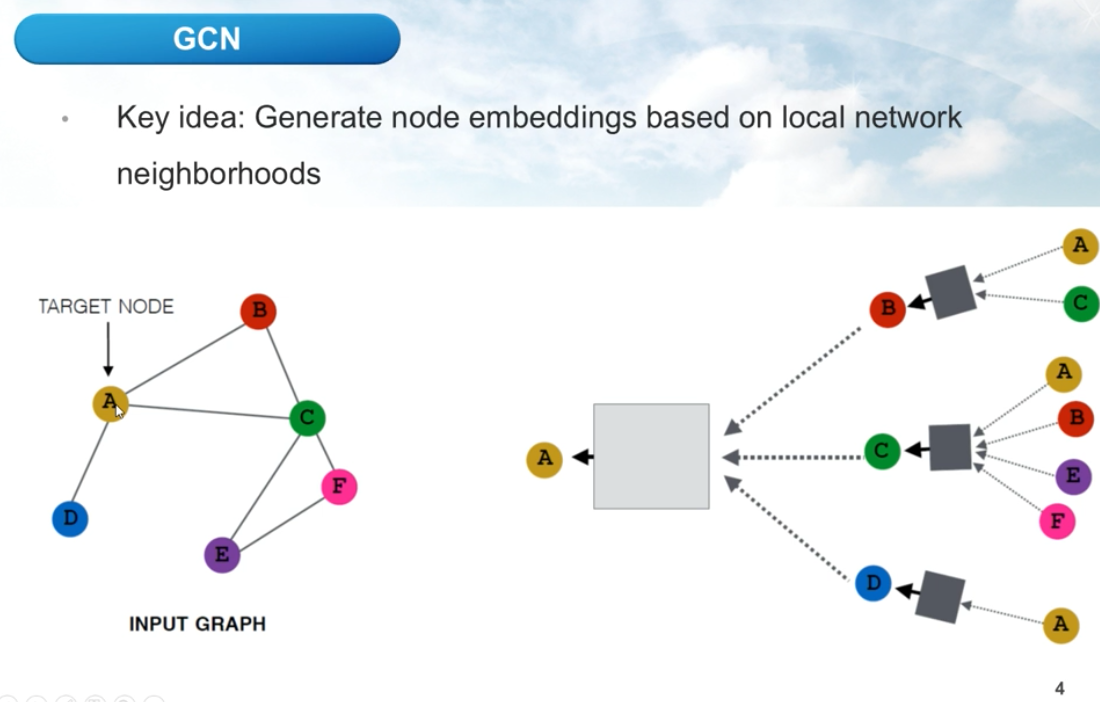

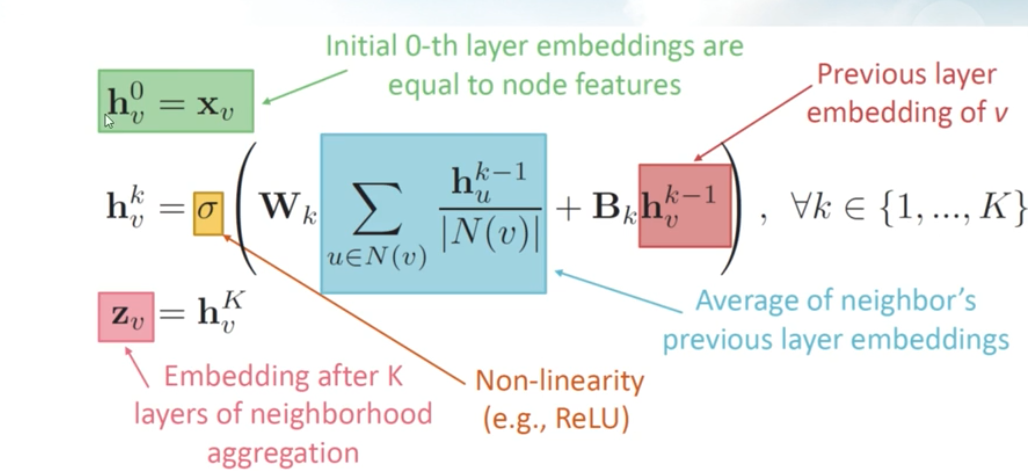

- Green box : 초기값. (node feature)
- Pink box : 마지막 값. (최종 embedding 값. k-layer를 거친 후의)
- Blue box : 이웃 노드들의 feature summation / 이웃노드 개수로 나누어주기
- Red box : 이전 레이어의 embedding 값
- W, B는 각각 학습가능한 파라미터

## ✔︎ GCN in DGL
https://docs.dgl.ai/en/0.9.x/generated/dgl.nn.pytorch.conv.GraphConv.html

In [ ]:
from dgl.nn import GraphConv

class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, num_classes)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

지금까지는 이렇게 GraphConv 레이어를 불러서 썼지만, 지금은 구체적으로 GraphConv 내에서 어떤 식으로 연산이 되는지 알아봅시다.

공식은 다음과 같이 정의됨.

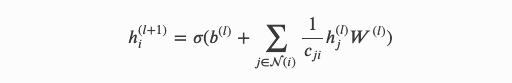

만약, edge weight가 있는 경우 다음과 같이 계산됨.

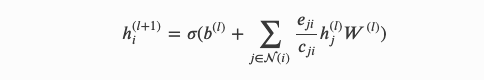

## ✔︎ Environment Setting

In [ ]:
import dgl
import dgl.function as fn
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph

## 1. 데이터 로드

In [ ]:
from dgl.data import CoraGraphDataset
def load_cora_data():
    dataset = CoraGraphDataset()
    g = dataset[0]
    features = g.ndata['feat']
    labels = g.ndata['label']
    train_mask = g.ndata['train_mask']
    test_mask = g.ndata['test_mask']
    return g, features, labels, train_mask, test_mask

In [ ]:
g, features, labels, train_mask, test_mask = load_cora_data()

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [ ]:
g

Graph(num_nodes=2708, num_edges=10556,
      ndata_schemes={'feat': Scheme(shape=(1433,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64), 'test_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'train_mask': Scheme(shape=(), dtype=torch.bool)}
      edata_schemes={'__orig__': Scheme(shape=(), dtype=torch.int64)})

In [ ]:
features.shape, labels.shape

(torch.Size([2708, 1433]), torch.Size([2708]))

In [ ]:
train_mask, test_mask

(tensor([False, False, False,  ..., False, False, False]),
 tensor([ True,  True, False,  ..., False, False, False]))

## 2. 모델 정의

### DGL에서의 그래프 연산
1. Message Function : 이웃 노드들의 feature를 모아 message 생성. 
2. Reduce Function : 여러 개의 message를 하나로 집계함. 
3. Update Function : 인자로 받은 Message Function, Reduce Function에 따라 노드 피쳐 업데이트

In [ ]:
gcn_msg = #-----code-----# # message 생성 
gcn_reduce = #-----code-----# # message 집계 

### Message Functions
- **copy_u(h, m)**: 출발 노드의 ‘h’ feature를 message의 ‘m’ feature에 넣어서 도착 노드에 전달
- **copy_e(h, m)**: 간선의 ‘h’ feature를 message의 ‘m’ feature에 넣어서 도착 노드에 전달
- **u_mul_e(hu, he, m)**: 출발 노드의 ‘hu’ feature와 간선의 ‘he’ feature를 곱하여 message의 ‘m’ feature에 넣어 도착 노드에 전달
- **u_add_v(hu, hv, m)**: 출발 노드의 ‘hu’ feature와 도착 노드의 ‘hv’ feature를 더하여 message의 ‘m’ feature에 넣어 도착 노드에 전달

### Reduce Functions
- **sum(m, h)**: 도착 노드가 받은 message의 ‘m’ feature들을 전부 더하여 도착 노드의 ‘h’ feature로 저장.
- **mean(m, h)**: 도착 노드가 받은 message의 ‘m’ feature들을 전부 평균 내어 도착 노드의 ‘h’ feature로 저장.
- **max(m, h)**: 도착 노드가 받은 message의 ‘m’ feature들에서 element-wise max 연산을 수행하여 도착 노드의 ‘h’ feature로 저장.
- **min(m, h)**: 도착 노드가 받은 message의 ‘m’ feature들을 element-wise min 연산을 수행하여 도착 노드의 ‘h’ feature로 저장.

In [ ]:
class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)

    def forward(self, g, feature):
        # Creating a local scope so that all the stored ndata and edata
        # (such as the `'h'` ndata below) are automatically popped out
        # when the scope exits.
        with g.local_scope():
            g.ndata['h'] = feature
            g.update_all(gcn_msg, gcn_reduce)
            h = g.ndata['h']
            return self.linear(h)

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = GCNLayer(1433, 16)
        self.layer2 = GCNLayer(16, 7)

    def forward(self, g, features):
        x = F.relu(self.layer1(g, features))
        x = self.layer2(g, x)
        return x
net = Net()
print(net)

Net(
  (layer1): GCNLayer(
    (linear): Linear(in_features=1433, out_features=16, bias=True)
  )
  (layer2): GCNLayer(
    (linear): Linear(in_features=16, out_features=7, bias=True)
  )
)


## 3. 훈련/평가 루프 정의

In [ ]:
def evaluate(model, g, features, labels, mask):
    model.eval()
    with th.no_grad():
        logits = model(g, features)
        logits = logits[mask]
        labels = labels[mask]
        _, indices = th.max(logits, dim=1)
        correct = th.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)

In [ ]:
import time
import numpy as np
g, features, labels, train_mask, test_mask = load_cora_data()

# Add edges between each node and itself to preserve old node representations
# ----- code ------ #

optimizer = th.optim.Adam(net.parameters(), lr=1e-2)

dur = []
for epoch in range(200):
    if epoch >=3:
        t0 = time.time()

    net.train()
    logits = net(g, features)
    logp = F.log_softmax(logits, 1)
    loss = F.nll_loss(logp[train_mask], labels[train_mask])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch >=3:
        dur.append(time.time() - t0)

    acc = evaluate(net, g, features, labels, test_mask)
    print("Epoch {:05d} | Loss {:.4f} | Test Acc {:.4f} | Time(s) {:.4f}".format(
            epoch, loss.item(), acc, np.mean(dur)))

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
Epoch 00000 | Loss 1.9642 | Test Acc 0.2460 | Time(s) nan
Epoch 00001 | Loss 1.8082 | Test Acc 0.4000 | Time(s) nan
Epoch 00002 | Loss 1.6098 | Test Acc 0.4750 | Time(s) nan
Epoch 00003 | Loss 1.4570 | Test Acc 0.5510 | Time(s) 0.0052
Epoch 00004 | Loss 1.3322 | Test Acc 0.6300 | Time(s) 0.0053
Epoch 00005 | Loss 1.2177 | Test Acc 0.6760 | Time(s) 0.0057
Epoch 00006 | Loss 1.1104 | Test Acc 0.6810 | Time(s) 0.0056
Epoch 00007 | Loss 1.0101 | Test Acc 0.6900 | Time(s) 0.0055
Epoch 00008 | Loss 0.9181 | Test Acc 0.7020 | Time(s) 0.0055
Epoch 00009 | Loss 0.8357 | Test Acc 0.7010 | Time(s) 0.0054
Epoch 00010 | Loss 0.7615 | Test Acc 0.6960 | Time(s) 0.0054
Epoch 00011 | Loss 0.6940 | Test Acc 0.6960 | Time(s) 0.0054
Epoch 00012 | Loss 0.6334 | Test Acc 0.6990 | Time(s) 0.0054
Epoch 00013 | Loss 0.5776 | Test A

/home/dsail/migyeongk/migyeongk_torch1.7/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dsail/migyeongk/migyeongk_torch1.7/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 00020 | Loss 0.2989 | Test Acc 0.7430 | Time(s) 0.0054
Epoch 00021 | Loss 0.2732 | Test Acc 0.7450 | Time(s) 0.0054
Epoch 00022 | Loss 0.2498 | Test Acc 0.7440 | Time(s) 0.0054
Epoch 00023 | Loss 0.2285 | Test Acc 0.7460 | Time(s) 0.0054
Epoch 00024 | Loss 0.2091 | Test Acc 0.7460 | Time(s) 0.0054
Epoch 00025 | Loss 0.1913 | Test Acc 0.7450 | Time(s) 0.0054
Epoch 00026 | Loss 0.1751 | Test Acc 0.7480 | Time(s) 0.0054
Epoch 00027 | Loss 0.1602 | Test Acc 0.7480 | Time(s) 0.0054
Epoch 00028 | Loss 0.1467 | Test Acc 0.7460 | Time(s) 0.0054
Epoch 00029 | Loss 0.1344 | Test Acc 0.7530 | Time(s) 0.0054
Epoch 00030 | Loss 0.1233 | Test Acc 0.7520 | Time(s) 0.0054
Epoch 00031 | Loss 0.1132 | Test Acc 0.7510 | Time(s) 0.0054
Epoch 00032 | Loss 0.1040 | Test Acc 0.7510 | Time(s) 0.0054
Epoch 00033 | Loss 0.0956 | Test Acc 0.7530 | Time(s) 0.0054
Epoch 00034 | Loss 0.0880 | Test Acc 0.7490 | Time(s) 0.0054
Epoch 00035 | Loss 0.0811 | Test Acc 0.7500 | Time(s) 0.0054
Epoch 00036 | Loss 0.074

Epoch 00163 | Loss 0.0020 | Test Acc 0.7380 | Time(s) 0.0054
Epoch 00164 | Loss 0.0020 | Test Acc 0.7380 | Time(s) 0.0054
Epoch 00165 | Loss 0.0020 | Test Acc 0.7380 | Time(s) 0.0054
Epoch 00166 | Loss 0.0020 | Test Acc 0.7370 | Time(s) 0.0054
Epoch 00167 | Loss 0.0019 | Test Acc 0.7370 | Time(s) 0.0054
Epoch 00168 | Loss 0.0019 | Test Acc 0.7370 | Time(s) 0.0054
Epoch 00169 | Loss 0.0019 | Test Acc 0.7370 | Time(s) 0.0054
Epoch 00170 | Loss 0.0019 | Test Acc 0.7370 | Time(s) 0.0054
Epoch 00171 | Loss 0.0019 | Test Acc 0.7370 | Time(s) 0.0054
Epoch 00172 | Loss 0.0018 | Test Acc 0.7370 | Time(s) 0.0054
Epoch 00173 | Loss 0.0018 | Test Acc 0.7370 | Time(s) 0.0054
Epoch 00174 | Loss 0.0018 | Test Acc 0.7370 | Time(s) 0.0054
Epoch 00175 | Loss 0.0018 | Test Acc 0.7370 | Time(s) 0.0054
Epoch 00176 | Loss 0.0018 | Test Acc 0.7370 | Time(s) 0.0054
Epoch 00177 | Loss 0.0018 | Test Acc 0.7370 | Time(s) 0.0054
Epoch 00178 | Loss 0.0017 | Test Acc 0.7370 | Time(s) 0.0054
Epoch 00179 | Loss 0.001